In [2]:
import requests, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import random
import math
from tabulate import tabulate
from scipy.stats import norm, ttest_ind, f_oneway, t, shapiro, levene, mannwhitneyu, wilcoxon, kruskal
import itertools
from matplotlib.ticker import MaxNLocator
import openai
openai.api_key = ''

In [2]:

def generate_nback_sequences(n, alphabet, seq_length, matches, num_sequences):
    sequences = []
    for _ in range(num_sequences):
        seq, conditions = [], []
        match_positions = random.sample(range(n, seq_length), matches)
        match_positions.sort()

        for i in range(seq_length):
            if i in match_positions:
                seq.append(seq[i - n])
                conditions.append('m')
            else:
                random_letter = random.choice(alphabet)
                while i > n and seq[i - n] == random_letter:
                    random_letter = random.choice(alphabet)
                seq.append(random_letter)
                conditions.append('-')
        
        sequences.append((''.join(seq), ''.join(conditions)))

    return sequences

def save_sequences_to_files(folder, sequences):
    os.makedirs(folder, exist_ok=True)

    for i, (seq, conditions) in enumerate(sequences):
        with open(os.path.join(folder, f"{i}.txt"), "w") as file:
            file.write(f"{seq}\n{conditions}\n")

alphabet = 'bcdfghjklnpqrstvwxyz'
seq_length = 30
matches = 10
num_sequences = 50

for n in [1, 2, 3]:
    sequences = generate_nback_sequences(n, alphabet, seq_length, matches, num_sequences)
    folder = os.path.join("letters_30", f"{n}back")
    save_sequences_to_files(folder, sequences)

In [3]:
server_address = "http://xxxx" # server where models are hosted

def check_model_status(model_name):
    url = server + model_name + "/status"
    headers = {"Authorization": "key-xxx"}
    resp = requests.post(url, json={}, headers=headers)
    return resp.json()

def activate_model(model_name):
    url = server_address + model_name + "/activate"
    headers = {"Authorization": "key-xxxx"}
    resp = requests.post(url, json={}, headers=headers)
    return resp.json()

def call_model(model_name, messages):
    if model_name == "gpt-3.5-turbo":
        completion = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=messages
            )
        return completion.choices[0].message.content
    elif model_name == "gpt-4":
        completion = openai.ChatCompletion.create(
            model="gpt-4",
            messages=messages
            )
        return completion.choices[0].message.content
    else:
        status = check_model_status(model_name)
        if status["model_server_status"] == False:
            print("Model is not activated, activating...")
            activate_model(model_name)

        url = server_address + model_name + "/call"
        body = {
            "messages": messages
        }
        headers = {"Authorization": "key-xxxx"}
        resp = requests.post(url, json=body, headers=headers)
        return resp.json()["result"]



In [4]:
# model list:
# ```
# Vicuna-13B
# Vicuna-7B
# bloomz-7b
# bloomz-7b1-mt
# chatglm-6b_v1.0
# chatglm-6b_v1.1
# gpt-3.5-turbo
# gpt-4

In [4]:
n_list = [1, 2, 3]
blocks = 30
model = "gpt-4"

In [5]:

# read N-back task (N=1,2,3) sequences and conditions from txt files, in which the first line is the sequence and the second line is the condition
# and create a list of trials
# each trial is a dictionary with the following keys:
# - 'stimulus': the stimulus letter
# - 'target': the desired response letter
# - 'response': the received response letter
# - 'correct': whether the response was correct
# - 'rt': the response time

all_trials = {}
for n in n_list:
    for b in range(blocks):
        path = os.path.join(os.getcwd(), 'letters_30','{}back'.format(n), '{}.txt'.format(b))
        with open(path, 'r') as f:
            seq = f.readline().strip()
            cond = f.readline().strip()

        # create a list of trials
        trials = []
        for i in range(len(seq)):
            trial = {}
            trial['stimulus'] = seq[i]
            trial['target'] = cond[i]
            trial['response'] = ''
            trial['correct'] = ''
            trial['rt'] = ''
            trials.append(trial)

        all_trials['{}back_{}'.format(n, b)] = trials


In [6]:
# define a function to retry requests that fail due to rate limits
def retry_request(messages, wait_time = 1, max_retries=5):
    n_try = 0
    while True:
        try:
            start_time = time.time()
            completion = call_model(model, messages)
            break
        except Exception as e:
            print(e)
            backoff_sec = wait_time * 2**(n_try+1)
            print(f"Waiting {backoff_sec} seconds...")
            time.sleep(backoff_sec)
            n_try += 1
            if n_try >= max_retries:
                print("Max retry exhausted and an error still occurs persistently.")
                raise e
    return completion,start_time

In [7]:

# First, we will run the 1-back task
for b in range(blocks):
    messages = [
        {"role": "user", "content" :"Instruction: as a language model, you are asked to perform a 1-back task. A letter will be presented on every trial. Your task is to respond with 'm' whenever the letter presented is the same as the previous letter, and '-' whenever the letter presented is different from the previous letter. A strict rule is that you must not output anything other than 'm' or '-'. Now begins the task."}
    ]
    for i in range(len(all_trials['1back_{}'.format(b)])):
        if i < 6:
            messages.append({"role": "user", "content": all_trials['1back_{}'.format(b)][i]['stimulus']})
            chat_response = all_trials['1back_{}'.format(b)][i]['target']
            all_trials['1back_{}'.format(b)][i]['response'] = chat_response
            all_trials['1back_{}'.format(b)][i]['correct'] = all_trials['1back_{}'.format(b)][i]['response'] == all_trials['1back_{}'.format(b)][i]['target']
            all_trials['1back_{}'.format(b)][i]['rt'] = np.inf
            print(f'block {b}, trial {i}: {all_trials["1back_{}".format(b)][i]["stimulus"]} (target: {all_trials["1back_{}".format(b)][i]["target"]})')
            print(f'Model: {chat_response}')
        else:
            input = all_trials['1back_{}'.format(b)][i]['stimulus']
            print(f'block {b}, trial {i}: {input} (target: {all_trials["1back_{}".format(b)][i]["target"]})')
            messages.append({"role": "user", "content": input})

            completion, start_time = retry_request(messages)

            # calculate the time it took to receive the response
            response_time = time.time() - start_time
            
            # store the response time in the trial
            all_trials['1back_{}'.format(b)][i]['rt'] = response_time
            print(f"Response time: {response_time:.2f} seconds")
            
            chat_response = completion
            print(f'Model: {chat_response}')
            
            # check if the response is 'm' or '-', if not, then the response is invalid and an error message is returned
            if chat_response == 'm':
              all_trials['1back_{}'.format(b)][i]['response'] = 'm'
              all_trials['1back_{}'.format(b)][i]['correct'] = all_trials['1back_{}'.format(b)][i]['target'] == 'm'
            elif chat_response == '-':
              all_trials['1back_{}'.format(b)][i]['response'] = '-'
              all_trials['1back_{}'.format(b)][i]['correct'] = all_trials['1back_{}'.format(b)][i]['target'] == '-'
            else:
              # Give a warning:
              print('Rule violation! Extracting the first letter of the response.')
              # extract the first letter of the response
              chat_response_0 = chat_response.strip()[0]
              if chat_response_0 != 'm' and chat_response_0 != '-':
                  messages.append({"role": "assistant", "content": chat_response})
                  messages.append({"role": "user", "content": "Your response is invalid. Please try again and respond with only 'm' or '-'."})
                  completion = call_model(model, messages)
                  chat_response = completion
                  print(f'Model: {chat_response}')
                  if chat_response:
                      chat_response_0 = chat_response.strip()[0]
                  else:
                      chat_response_0 = chat_response
              
              if chat_response_0 != 'm' and chat_response_0 != '-':
                  if all_trials['1back_{}'.format(b)][i]['target'] == 'm':
                      chat_response = '-'
                  else:
                      chat_response = 'm'
              else:
                  chat_response = chat_response_0
              all_trials['1back_{}'.format(b)][i]['response'] = chat_response
              all_trials['1back_{}'.format(b)][i]['correct'] = all_trials['1back_{}'.format(b)][i]['target'] == chat_response
                
        # print 'correct' or 'incorrect' based on the response
        print('correct' if all_trials['1back_{}'.format(b)][i]['correct'] else 'incorrect')
        print('------------------------------------')
        
        messages.append({"role": "assistant", "content": chat_response})

    # wait for 5 seconds before the next block
    time.sleep(1)

block 0, trial 0: p (target: -)
Model: -
correct
------------------------------------
block 0, trial 1: b (target: -)
Model: -
correct
------------------------------------
block 0, trial 2: v (target: -)
Model: -
correct
------------------------------------
block 0, trial 3: v (target: m)
Model: m
correct
------------------------------------
block 0, trial 4: f (target: -)
Model: -
correct
------------------------------------
block 0, trial 5: n (target: -)
Model: -
correct
------------------------------------
block 0, trial 6: l (target: -)
Response time: 0.92 seconds
Model: -
correct
------------------------------------
block 0, trial 7: y (target: -)
Response time: 1.22 seconds
Model: -
correct
------------------------------------
block 0, trial 8: l (target: -)
Response time: 0.94 seconds
Model: -
correct
------------------------------------
block 0, trial 9: g (target: -)
Response time: 0.88 seconds
Model: -
correct
------------------------------------
block 0, trial 10: g (target

In [8]:

# then, we will run the 2-back task
for b in range(blocks):
    messages = [
        {"role": "user", "content" :"Instruction: as a language model, you are asked to perform a 2-back task. A letter will be presented on every trial. Your task is to respond with 'm' whenever the letter presented is the same as the letter two trials ago, and '-' whenever the letter presented is different from the letter two trials ago. A strict rule is that you must not output anything other than 'm' or '-'. Now begins the task."}
    ]
    for i in range(len(all_trials['2back_{}'.format(b)])):
        if i < 6:
            messages.append({"role": "user", "content": all_trials['2back_{}'.format(b)][i]['stimulus']})
            chat_response = all_trials['2back_{}'.format(b)][i]['target']
            all_trials['2back_{}'.format(b)][i]['response'] = chat_response
            all_trials['2back_{}'.format(b)][i]['correct'] = all_trials['2back_{}'.format(b)][i]['response'] == all_trials['2back_{}'.format(b)][i]['target']
            all_trials['2back_{}'.format(b)][i]['rt'] = np.inf
            print(f'block {b}, trial {i}: {all_trials["2back_{}".format(b)][i]["stimulus"]} (target: {all_trials["2back_{}".format(b)][i]["target"]})')
            print(f'Model: {chat_response}')
        else:
            input = all_trials['2back_{}'.format(b)][i]['stimulus']
            print(f'block {b}, trial {i}: {input} (target: {all_trials["2back_{}".format(b)][i]["target"]})')
            messages.append({"role": "user", "content": input})
            
            completion, start_time = retry_request(messages)

            # calculate the time it took to receive the response
            response_time = time.time() - start_time

            # store the response time in the trial
            all_trials['2back_{}'.format(b)][i]['rt'] = response_time
            print(f"Response time: {response_time:.2f} seconds")

            chat_response = completion
            print(f'Model: {chat_response}')

            # check if the response is 'm' or '-', if not, then the response is invalid and an error message is returned
            if chat_response == 'm':
              all_trials['2back_{}'.format(b)][i]['response'] = 'm'
              all_trials['2back_{}'.format(b)][i]['correct'] = all_trials['2back_{}'.format(b)][i]['target'] == 'm'
            elif chat_response == '-':
              all_trials['2back_{}'.format(b)][i]['response'] = '-'
              all_trials['2back_{}'.format(b)][i]['correct'] = all_trials['2back_{}'.format(b)][i]['target'] == '-'
            else:
              # Give a warning:
              print('Rule violation! Extracting the first letter of the response.')
              # extract the first letter of the response
              chat_response_0 = chat_response.strip()[0]
              if chat_response_0 != 'm' and chat_response_0 != '-':
                  messages.append({"role": "assistant", "content": chat_response})
                  messages.append({"role": "user", "content": "Your response is invalid. Please try again and respond with only 'm' or '-'."})
                  completion = call_model(model, messages)
                  chat_response = completion
                  print(f'Model: {chat_response}')
                  if chat_response:
                      chat_response_0 = chat_response.strip()[0]
                  else:
                      chat_response_0 = chat_response
              
              if chat_response_0 != 'm' and chat_response_0 != '-':
                  if all_trials['2back_{}'.format(b)][i]['target'] == 'm':
                      chat_response = '-'
                  else:
                      chat_response = 'm'
              else:
                  chat_response = chat_response_0
              all_trials['2back_{}'.format(b)][i]['response'] = chat_response
              all_trials['2back_{}'.format(b)][i]['correct'] = all_trials['2back_{}'.format(b)][i]['target'] == chat_response

        # print 'correct' or 'incorrect' based on the response
        print('correct' if all_trials['2back_{}'.format(b)][i]['correct'] else 'incorrect')
        print('------------------------------------')
        
        messages.append({"role": "assistant", "content": chat_response})

    # wait for 1 seconds before the next block
    time.sleep(1)
                

block 0, trial 0: t (target: -)
Model: -
correct
------------------------------------
block 0, trial 1: z (target: -)
Model: -
correct
------------------------------------
block 0, trial 2: t (target: m)
Model: m
correct
------------------------------------
block 0, trial 3: l (target: -)
Model: -
correct
------------------------------------
block 0, trial 4: c (target: -)
Model: -
correct
------------------------------------
block 0, trial 5: l (target: m)
Model: m
correct
------------------------------------
block 0, trial 6: c (target: m)
Response time: 0.65 seconds
Model: m
correct
------------------------------------
block 0, trial 7: r (target: -)
Response time: 0.65 seconds
Model: -
correct
------------------------------------
block 0, trial 8: h (target: -)
Response time: 0.42 seconds
Model: -
correct
------------------------------------
block 0, trial 9: y (target: -)
Response time: 1.01 seconds
Model: -
correct
------------------------------------
block 0, trial 10: h (target

In [9]:

# then, we will run the 3-back task
for b in range(blocks):
    messages = [
        {"role": "user", "content" :"Instruction: as a language model, you are asked to perform a 3-back task. A letter will be presented on every trial. Your task is to respond with 'm' whenever the letter presented is the same as the letter three trials ago, and '-' whenever the letter presented is different from the letter three trials ago. A strict rule is that you must not output anything other than 'm' or '-'. Now begins the task."}
    ]
    for i in range(len(all_trials['3back_{}'.format(b)])):
        if i < 6:
            messages.append({"role": "user", "content": all_trials['3back_{}'.format(b)][i]['stimulus']})
            chat_response = all_trials['3back_{}'.format(b)][i]['target']
            all_trials['3back_{}'.format(b)][i]['response'] = chat_response
            all_trials['3back_{}'.format(b)][i]['correct'] = all_trials['3back_{}'.format(b)][i]['response'] == all_trials['3back_{}'.format(b)][i]['target']
            all_trials['3back_{}'.format(b)][i]['rt'] = np.inf
            print(f'block {b}, trial {i}: {all_trials["3back_{}".format(b)][i]["stimulus"]} (target: {all_trials["3back_{}".format(b)][i]["target"]})')
            print(f'Model: {chat_response}')
        else:
            input = all_trials['3back_{}'.format(b)][i]['stimulus']
            print(f'block {b}, trial {i}: {input} (target: {all_trials["3back_{}".format(b)][i]["target"]})')
            messages.append({"role": "user", "content": input})
            
            completion, start_time = retry_request(messages)

            # calculate the time it took to receive the response
            response_time = time.time() - start_time

            # store the response time in the trial
            all_trials['3back_{}'.format(b)][i]['rt'] = response_time
            print(f"Response time: {response_time:.2f} seconds")

            chat_response = completion
            print(f'Model: {chat_response}')

            # check if the response is 'm' or '-', if not, then the response is invalid and an error message is returned
            if chat_response == 'm':
              all_trials['3back_{}'.format(b)][i]['response'] = 'm'
              all_trials['3back_{}'.format(b)][i]['correct'] = all_trials['3back_{}'.format(b)][i]['target'] == 'm'
            elif chat_response == '-':
              all_trials['3back_{}'.format(b)][i]['response'] = '-'
              all_trials['3back_{}'.format(b)][i]['correct'] = all_trials['3back_{}'.format(b)][i]['target'] == '-'
            else:
              # Give a warning:
              print('Rule violation! Extracting the first letter of the response.')
              # extract the first letter of the response
              chat_response_0 = chat_response.strip()[0]
              if chat_response_0 != 'm' and chat_response_0 != '-':
                  messages.append({"role": "assistant", "content": chat_response})
                  messages.append({"role": "user", "content": "Your response is invalid. Please try again and respond with only 'm' or '-'."})
                  completion = call_model(model, messages)
                  chat_response = completion
                  print(f'Model: {chat_response}')
                  if chat_response:
                      chat_response_0 = chat_response.strip()[0]
                  else:
                      chat_response_0 = chat_response
              
              if chat_response_0 != 'm' and chat_response_0 != '-':
                  if all_trials['3back_{}'.format(b)][i]['target'] == 'm':
                      chat_response = '-'
                  else:
                      chat_response = 'm'
              else:
                  chat_response = chat_response_0
              all_trials['3back_{}'.format(b)][i]['response'] = chat_response
              all_trials['3back_{}'.format(b)][i]['correct'] = all_trials['3back_{}'.format(b)][i]['target'] == chat_response

        # print 'correct' or 'incorrect' based on the response
        print('correct' if all_trials['3back_{}'.format(b)][i]['correct'] else 'incorrect')
        print('------------------------------------')
        
        messages.append({"role": "assistant", "content": chat_response})

    # wait for 1 seconds before the next block
    time.sleep(1)
                

block 0, trial 0: w (target: -)
Model: -
correct
------------------------------------
block 0, trial 1: r (target: -)
Model: -
correct
------------------------------------
block 0, trial 2: j (target: -)
Model: -
correct
------------------------------------
block 0, trial 3: q (target: -)
Model: -
correct
------------------------------------
block 0, trial 4: b (target: -)
Model: -
correct
------------------------------------
block 0, trial 5: t (target: -)
Model: -
correct
------------------------------------
block 0, trial 6: q (target: m)
Response time: 0.70 seconds
Model: m
correct
------------------------------------
block 0, trial 7: n (target: -)
Response time: 0.56 seconds
Model: -
correct
------------------------------------
block 0, trial 8: t (target: m)
Response time: 0.78 seconds
Model: m
correct
------------------------------------
block 0, trial 9: h (target: -)
Response time: 0.74 seconds
Model: -
correct
------------------------------------
block 0, trial 10: g (target

In [10]:
# save all_trials to a json file, include model name in the file name
with open('all_trials_verbal_{}.json'.format(model), 'w') as f:
    json.dump(all_trials, f)


In [ ]:
n_list = [1, 2, 3]
def compute_summary_stats(all_trials, n_list, blocks):
    summary_stats = {}
    raw_data = {}
    for n in n_list:
        hit_rate, false_alarm_rate, accuracy, response_time, d_prime = [], [], [], [], []
        for b in range(blocks):
            trials = all_trials[f"{n}back_{b}"]

            # Compute the hit rate, false alarm rate, and response time
            hits, false_alarms, total_targets, total_lures, total_rt = 0, 0, 0, 0, 0
            for trial in trials:
                if trial['target'] == 'm':
                    total_targets += 1
                    if trial['correct']:
                        hits += 1
                        total_rt += trial['rt']
                else:
                    total_lures += 1
                    if not trial['correct']:
                        false_alarms += 1

            hit_rate.append((hits / total_targets) * 100)
            false_alarm_rate.append((false_alarms / total_lures) * 100)
            accuracy.append(((hits + (total_lures - false_alarms)) / (total_targets + total_lures)) * 100)
            response_time.append(total_rt / hits if hits > 0 else np.nan)

            # Compute d prime
            hit_rate_adjusted = np.clip(hits / total_targets, 0.01, 0.99)
            false_alarm_rate_adjusted = np.clip(false_alarms / total_lures, 0.01, 0.99)
            d_prime.append(np.abs(norm.ppf(hit_rate_adjusted) - norm.ppf(false_alarm_rate_adjusted)))

        raw_data[n] = {
            "hit_rate": hit_rate,
            "false_alarm_rate": false_alarm_rate,
            "accuracy": accuracy,
            "d_prime": d_prime
        }
            
        summary_stats[n] = {
            "hit_rate": {"mean": np.mean(hit_rate),  "stderr": np.std(hit_rate) / math.sqrt(blocks)},
            "false_alarm_rate": {"mean": np.mean(false_alarm_rate), "stderr": np.std(false_alarm_rate) / math.sqrt(blocks)},
            "accuracy": {"mean": np.mean(accuracy), "stderr": np.std(accuracy) / math.sqrt(blocks)},
            "d_prime": {"mean": np.mean(d_prime), "stderr": np.std(d_prime) / math.sqrt(blocks)}
        }
    return summary_stats, raw_data

def create_table(summary_stats, n_list):
    headers = ["N-back", "Hit Rate (%)", "False Alarm Rate (%)",
               "Accuracy (%)", "D Prime"]

    table_data = []
    for n in n_list:
        row = [f"{n}-back",
               f"{summary_stats[n]['hit_rate']['mean']:.2f} ± {summary_stats[n]['hit_rate']['stderr']:.2f}",
               f"{summary_stats[n]['false_alarm_rate']['mean']:.2f} ± {summary_stats[n]['false_alarm_rate']['stderr']:.2f}",
               f"{summary_stats[n]['accuracy']['mean']:.2f} ± {summary_stats[n]['accuracy']['stderr']:.2f}",
               f"{summary_stats[n]['d_prime']['mean']:.2f} ± {summary_stats[n]['d_prime']['stderr']:.2f}"]
        table_data.append(row)

    table_str = tabulate(table_data, headers=headers, tablefmt="latex_booktabs")
    return table_str

# Compute summary statistics
summary_stats, raw_data = compute_summary_stats(all_trials, n_list, blocks)

# Create and print the table in LaTeX format
latex_table = create_table(summary_stats, n_list)
print(latex_table)


\begin{tabular}{lllll}
\toprule
 N-back   & Hit Rate (\%)   & False Alarm Rate (\%)   & Accuracy (\%)   & D Prime     \\
\midrule
 1-back   & 28.67 ± 3.05   & 22.33 ± 4.23           & 61.33 ± 3.13   & 1.02 ± 0.10 \\
 2-back   & 29.33 ± 3.02   & 30.00 ± 4.37           & 56.44 ± 3.27   & 0.91 ± 0.11 \\
 3-back   & 25.00 ± 3.32   & 38.50 ± 4.96           & 49.33 ± 3.38   & 0.99 ± 0.13 \\
\bottomrule
\end{tabular}


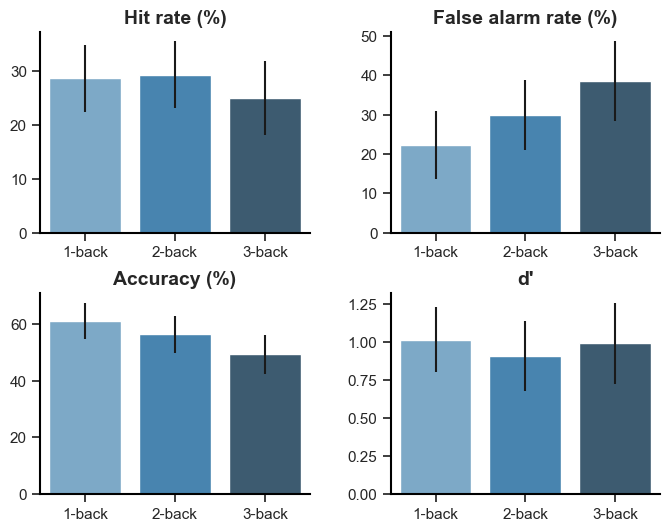

In [ ]:
def plot_metrics(summary_stats, n_list, ci_level=0.95):
    # Set seaborn style and font size
    sns.set(style="whitegrid")
    plt.rcParams.update({'font.size': 12})

    # Bar plot for accuracy, hit rate, false alarm rate, and d prime
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    metrics = ["hit_rate", "false_alarm_rate","accuracy", "d_prime"]
    titles = ["Hit rate (%)", "False alarm rate (%)", "Accuracy (%)", "d'"]

    for i, ax in enumerate(axes.flat):
        metric = metrics[i]
        means = [summary_stats[n][metric]["mean"] for n in n_list]
        stderrs = [summary_stats[n][metric]["stderr"] for n in n_list]
        # Compute 95% confidence intervals
        critical_value = t.ppf((1 + ci_level) / 2, blocks - 1)
        cis = [critical_value * stderr for stderr in stderrs]
        # Choose either standard errors or confidence intervals for error bars
        error_bars = cis # Change this to 'stderrs' for standard errors
        bar_plot = sns.barplot(x=n_list, y=means, yerr=error_bars, ax=ax, palette="Blues_d")
        ax.set_title(titles[i], fontsize=14, fontweight='bold')
        ax.set_xticklabels([f"{n}-back" for n in n_list])
        ax.set_ylim(bottom=0)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # remove the grid lines
        ax.grid(False)
        # set the weight  and color of axes lines
        ax.spines['bottom'].set_linewidth(1.5)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        # show tick lines on the left and bottom axes
        ax.tick_params(axis='both', which='both', bottom=True, left=True)


    # layout setting: adjust the space between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()

plot_metrics(summary_stats, n_list)

